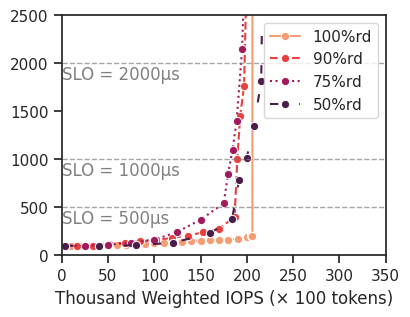

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

CALIBRATED = False
CALIBRATED = True
OLD = False
WEIGHT = 4
file_path = 'IOPS.data'
# file_path = 'IOPS_0618.data'
# file_path = 'IOPS_0619.data'
# file_path = 'IOPS_0619x.data'
# file_path = 'IOPS_0620.data'
# file_path = 'IOPS_0620x.data'
# file_path = 'IOPS_0620n.data'
# file_path = 'IOPS_0620xn.data'
file_path = 'IOPS_0623xn.data'
file_path = 'IOPS_0625.data'
# file_path = 'IOPS_0625x.data'
file_path = 'IOPS_0625xn2.data'
file_path = 'IOPS_0626x.data'
# file_path = 'IOPS_0626xn.data'
file_path = 'IOPS_0626.data'
# file_path = 'IOPS_0703.data'
file_path = 'IOPS_0710.data'

# Read the data from the file
with open(file_path, 'r') as file:
    data = file.read()

lines = data.strip().split("\n")
sns.set(style="ticks", font_scale=1)
# Split the data string into lines

# Prepare empty lists to hold the parsed data
hues = []
sizes = []
xs = []
ys = []
weights = {
    4: 7,
    16: 10,
    64: 10,
}
weights4ratio = {
    50: 7,
    75: 7,
    90: 8,
    100: 1,
}
if OLD:
    weights[4] = 4

# plt.figure(figsize=(5, 4))  # Width=12 inches, Height=6 inches
plt.figure(figsize=(4, 3))  # Width=12 inches, Height=6 inches
pending_hues = [50, 75, 90, 100]
# pending_hues = [50, 75, 90, 95, 99, 100]
latency_break = 2500

X_SELECT = True

for i in range(0, len(lines), 4):
    if lines[i][0] == '#':
        continue
    parts = list(map(int, lines[i].split()))
    if X_SELECT:
        if len(parts) == 3:
            hue, _, size = parts
        elif len(parts) == 2:
            hue, _ = parts
            size = 4
        # print(f"parsing line {i} with hue {hue} and size {size}KB")
    else:
        if len(parts) == 3:
            hue, x, size = parts
        elif len(parts) == 2:
            hue, x = parts
        x /= 1000

    try:
        if X_SELECT:
            x, y = map(float, lines[i+2].split())
            if size != 323 and size != 333:
                x *= (size / 4)
            x /= (hue / 100 * 1000)
        else:
            y = float(lines[i+2].split()[1])

        if hue in pending_hues:
            hues.append(f"{hue}%rd")
            sizes.append(size)
            if CALIBRATED:
                ratio = hue / 100
                # x = x * ratio + x * (1 - ratio) * weights[size]
                x = x * ratio + x * (1 - ratio) * weights4ratio[hue]
            xs.append(x)
            ys.append(y)
    except IndexError:
        print(f"skipping line {i+2}")

# 创建DataFrame
df = pd.DataFrame({'Hue': hues, 'Size': sizes, 'X': xs, 'Y': ys})

# 定义唯一的 hues 和 sizes
unique_hues = df['Hue'].unique()
unique_sizes = df['Size'].unique()

# 创建标记样式
markers = ['o', 's', '^', '<', '>', 'D', 'v']

# 创建线条样式，较小的 read ratio 使用更虚线的线条
line_styles = {
    50: (0, (4, 10)),
    75: ':',
    90: '--',
    95: (0, (5, 10)),
    99: '-.',
    100: '-',
}

palettes = {
    4: sns.color_palette("rocket_r", n_colors=len(unique_hues)),
    16: sns.color_palette("Set2_r", n_colors=len(unique_hues)),
    64: sns.color_palette("viridis", n_colors=len(unique_hues)),
}


# 绘制每个子集
for size in unique_sizes:
    if size in palettes:
        palette = palettes[size]
    else:
        palette = sns.color_palette("husl", n_colors=len(unique_hues))  # 默认调色板

    for hue in unique_hues:
        # print(subset)
        subset = df[(df['Hue'] == hue) & (df['Size'] == size)]
        if not subset.empty:
            hue_value = int(hue.split('%')[0])  # 提取百分比数值
            # label_name = f'{hue}, {size}KiB'
            label_name = f'{hue}'
            sns.lineplot(
                data=subset, x='X', y='Y', 
                marker=markers[unique_sizes.tolist().index(size) % len(markers)], 
                color=palette[unique_hues.tolist().index(hue) % len(palette)], 
                linestyle=line_styles.get(hue_value, '-'),  # 默认使用实线
                label=label_name
            )

# plt.xlim(0, 250)
plt.ylim(0, latency_break)
if CALIBRATED:
    plt.xlabel(f'Thousand Weighted IOPS (× 100 tokens)')
    # plt.xlabel(f'Thousand Weighted IOPS, W={weights[4]}R')
    plt.xlim(0, 350)
    plt.legend(title='', loc='upper right')
else:
    plt.xlabel('Thousand 4KiB IOPS')
    plt.legend(title='', loc='upper right')

if CALIBRATED:
    # Add horizontal lines for SLOs
    plt.axhline(y=500, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=1000, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=2000, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    # Add text labels for SLOs
    x_left = plt.xlim()[0]  # Get the leftmost x-coordinate
    plt.text(x_left, 480, 'SLO = 500μs', verticalalignment='top', horizontalalignment='left', color='gray', fontsize=12)
    plt.text(x_left, 980, 'SLO = 1000μs', verticalalignment='top', horizontalalignment='left', color='gray', fontsize=12)
    plt.text(x_left, 1980, 'SLO = 2000μs', verticalalignment='top', horizontalalignment='left', color='gray', fontsize=12)

    if OLD:
        plt.ylabel('Read p95 tail latency (μs)')
        plt.subplots_adjust(left=0.2, bottom=0.18, top=0.98, right=0.96)
        plt.savefig('SSD_Profile_Calibrated_old.png', dpi=300)
    else:
        plt.ylabel('')
        plt.subplots_adjust(left=0.15, bottom=0.18, top=0.98, right=0.96)
        plt.savefig('SSD_Profile_Calibrated.png', dpi=300)
else:
    assert OLD == False
    plt.ylabel('Read p95 tail latency (μs)')
    plt.subplots_adjust(left=0.2, bottom=0.18, top=0.98, right=0.98)
    plt.savefig('SSD_Profile.png', dpi=300)
    
plt.show()

In [5]:
# convert IOPS.data to csv
# with open('IOPS.data', 'r') as file:
with open('IOPS_0626xn.data', 'r') as file:
    data = file.read()
lines = data.strip().split("\n")
pending_hues = [50, 75, 90, 100]
pending_hues = [50, 75, 90]
pending_hues = [75]
X_SELECT = True
CALIBRATED = False

for i in range(0, len(lines), 4):
    parts = list(map(int, lines[i].split()))
    if X_SELECT:
        if len(parts) == 3:
            hue, _, size = parts
        elif len(parts) == 2:
            hue, iops = parts
            size = 4
        # print(f"parsing line {i} with hue {hue} and size {size}KB")
    else:
        if len(parts) == 3:
            hue, x, size = parts
        elif len(parts) == 2:
            hue, x = parts

    try:
        if X_SELECT:
            x, y = map(float, lines[i+2].split())
            if size != 323 and size != 333:
                x *= (size / 4)
            x /= (hue / 100)
        else:
            y = float(lines[i+2].split()[1])

        if hue in pending_hues:
            if CALIBRATED:
                ratio = hue / 100
                # x = x * ratio + x * (1 - ratio) * weights[size]
                x = x * ratio + x * (1 - ratio) * weights4ratio[hue]
            print(f"{iops},{x:.1f},{hue},{y},storage")
    except IndexError:
        print(f"skipping line {i+2}")

1000,1002.3,75,94.386,storage
20000,20019.2,75,97.503,storage
40000,40020.3,75,134.456,storage
60000,60044.7,75,146.922,storage
80000,80039.1,75,170.073,storage
100000,100042.6,75,215.485,storage
120000,120043.4,75,350.831,storage
140000,140021.6,75,737.28,storage
160000,160014.9,75,1068.522,storage
180000,179490.0,75,1374.831,storage
200000,194285.8,75,1595.659,storage
220000,202886.8,75,1759.499,storage
240000,208907.2,75,1837.857,storage
260000,212640.3,75,1909.092,storage
280000,214611.2,75,1980.327,storage
300000,218069.8,75,2023.068,storage
320000,218762.0,75,2051.562,storage


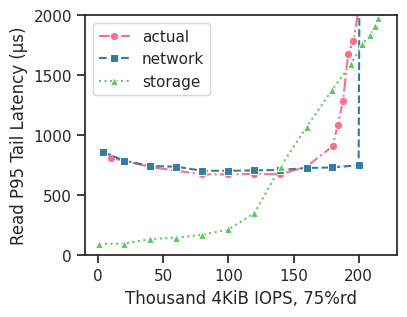

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

selection=50
selection=75
# selection=90
sns.set(style="ticks", font_scale=1)
# df = pd.read_csv(f'E2E{selection}.data')
df = pd.read_csv(f'E2E{selection}x.data')
df['actual_iops'] = df['actual_iops'] / 1000
unique_labels = ['actual', 'network', 'storage']
# statistical derived from storage and network
# req_iops = req_iops
# actual_iops = min(storage, network)
# p95_latency_us = p99(storage) + p96(network)

palettes = {
    'actual_bp': sns.color_palette("rocket", n_colors=len(unique_labels)),
    'network': sns.color_palette("mako", n_colors=len(unique_labels)),
    'storage': sns.color_palette("viridis", n_colors=len(unique_labels)),
    'actual': sns.color_palette("husl", n_colors=len(unique_labels)),
}

markers = ['o', 's', '^', '<', '>', 'D', 'v']

line_styles = {
    'actual_bp': '-',
    'actual': '-.',
    'network': '--',
    'storage': ':',
}

plt.figure(figsize=(4, 3))
for label in unique_labels:
    subset = df[df['label'] == label]
    palette = palettes[label]
    marker = markers[unique_labels.index(label) % len(markers)]
    linestyle = line_styles[label]
    
    sns.lineplot(
        data=subset, x='actual_iops', y='p95_latency_us', 
        marker=marker, 
        color=palette[unique_labels.index(label) % len(palette)], 
        linestyle=linestyle, 
        label=label
    )

plt.xlabel(f'Thousand 4KiB IOPS, {selection}%rd')
plt.ylabel('Read P95 Tail Latency (μs)')
# plt.ylabel('')
plt.legend(title='', loc="upper left",)
plt.ylim(0, 2000)
# plt.subplots_adjust(left=0.15, bottom=0.18, top=0.98, right=0.96)
plt.subplots_adjust(left=0.2, bottom=0.18, top=0.98, right=0.98)
plt.savefig(f'E2E_Profile_{selection}rd.png', dpi=300)
plt.show()